### This file has code for Exotic & Path Dependent Options pricing

    1. Fixed Strike Lookback Call and Put options
    2. Barrier Options
    3. Asian Options
    4. Volatility Swaps and Variance Swaps
    5. Simulation of Jump-Diffusions
    

In [2]:
import numpy as np
from numpy import sqrt, log, sin, cos, exp, pi, mean, repeat, var, matmul, transpose, ceil
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

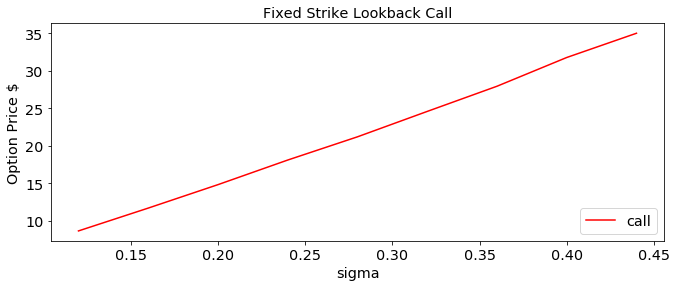

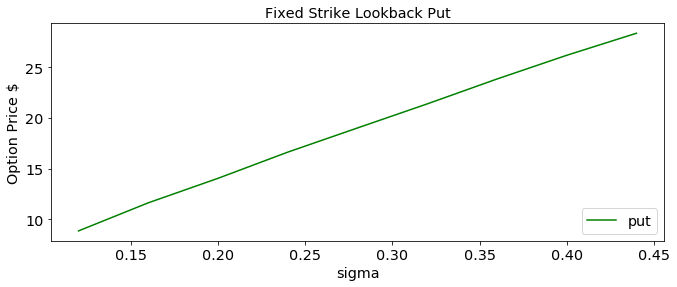

In [3]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (11, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

################### Ques 1 ###############################
def FSLCP(S0, K, sigma, r, T, paths, delta, option):
    N = int(T/delta)
    z1 = np.random.randn(int(paths/2+1), N)
    z2 = -z1
    Z = np.concatenate((z1, z2), axis=0)
    S = np.zeros((paths, N+1))
    S[:, 0] = S0
    for i in range(paths):
        for j in range(N):
            S[i, j+1] = S[i, j] + r*S[i, j]*delta + sigma*S[i, j]*sqrt(delta)*Z[i, j]
    
    if(option == "call"):
        payoff = np.amax(S, axis=1)-K
    elif(option == "put"):
        payoff = K-np.amin(S, axis=1)
        
    payoff = np.where(payoff>0, payoff, 0)
    price = exp(-r*T)*mean(payoff)
    return price
             
def ques1(seed):
    np.random.seed(seed)
    S0 = 98
    K = 100
    r = 0.03
    sigma = np.arange(0.12, 0.48, 0.04)
    T = 1 
    N = 100
    delta = T/N
    paths = 10000 
    prices = np.zeros(sigma.shape[0])
    
    option = "call"
    for i in range(sigma.shape[0]):
        prices[i] = FSLCP(S0, K, sigma[i], r, T, paths, delta, option)
    plt.figure(1)
    plt.plot(sigma, prices, 'r', label='call')
    
    plt.title("Fixed Strike Lookback Call")
    plt.xlabel("sigma")
    plt.ylabel("Option Price $")
    plt.legend(loc='lower right')
   
    option = "put"
    for i in range(sigma.shape[0]):
        prices[i] = FSLCP(S0, K, sigma[i], r, T, paths, delta, option)
    plt.figure(2)
    plt.plot(sigma, prices, 'g', label='put')
       
    plt.title("Fixed Strike Lookback Put")
    plt.xlabel("sigma")
    plt.ylabel("Option Price $")
    plt.legend(loc='lower right')

ques1(100)


In [5]:
##################################### Ques 2 #################################
#inputs
seed = 1234    
V0 = 20000
L0 = 22000
mu = -0.1
sigma = 0.2
gamma = -0.4
r0 = 0.02
delta = 0.25
epsilon = 0.95
alpha = 0.7


def collateralPaths(seed, V0, mu, sigma, T, lambda1, gamma, steps, paths):
    dt = 1/(12*steps)
    
    z1 = np.random.randn(int(ceil(paths/2)), T*12*steps+1)
    z2 = -z1
    Z = np.concatenate((z1, z2), axis=0) 
    #this line will take care of odd number of paths in case of antithetic simulation
    Z = Z[0:paths, :]
    dJ = np.random.poisson(lambda1/(12*steps), (paths, T*12*steps+1))
    
    V = np.zeros((paths, T*12*steps+1))
    V[:, 0] = V0
    np.random.seed(seed)
    for i in range (T*12*steps):
        V[:, i+1] = V[:, i] + V[:, i]*( mu*dt + sigma*sqrt(dt)*Z[:, i] + gamma*dJ[:, i] )
    
    installmentsTime = np.arange(0, T*12*steps+steps, steps)
    # returning value of collateral at the end of each month
    return V[:, installmentsTime]    


def Proj6_2func(lambda1=0.2, lambda2=0.4, T=1):
    
    #simulation steps between each month
    steps= 100
    paths = 10000
    #dim = paths*steps+1
    V = collateralPaths(seed, V0, mu, sigma, T, lambda1, gamma, steps, paths)
    # number of months T = years
    n = T*12
    R = r0+delta*lambda2
    r = R/12
    PMT = (L0*r)/abs((1-1/(1+r)**n))
    a = PMT/r
    b = PMT/(r*(1+r)**n)
    c = (1+r)
    #dim = 1*steps+1
    L = a - b*c**(12*np.arange(0, T+1/13, 1/12))
    
    beta = (epsilon-alpha)/T
    #dim = 1*steps+1
    qt = alpha + beta*np.arange(0, T+1/13, 1/12)
    
    Nt = np.random.poisson(lambda2/n, (paths, n+1))
    
    discountFactor = exp(-r0*np.arange(0, T+1/13, 1/12))

    Q = np.where(V<=qt*L, 1, 0)
    #column number of first occurance of 1 in each row
    Q = firstnon0rest0(Q)
    
    #payoff
    Qpayoff = L*Q-epsilon*V*Q
    Qpayoff = np.where(Qpayoff>0, Qpayoff, 0)
    QdiscountedPayoff = discountFactor*Qpayoff
    
    S = np.where(Nt>0, 1, 0)
    #first occurance of 1 in each row
    S = firstnon0rest0(S)
    Spayoff = abs(L*S-epsilon*V*S)
    SdiscountedPayoff = discountFactor*Spayoff
    
    combinedPayoff = np.maximum(QdiscountedPayoff, SdiscountedPayoff)
    combinedPayoff = firstnon0rest0(combinedPayoff)
    
    #price of default option
    price = np.sum(combinedPayoff)/paths
    #probability of default
    prob = np.count_nonzero(combinedPayoff)/paths
    #expected exercise time in years
    expectedExerciseTime = sum(combinedPayoff.argmax(1))/(12*paths)
    
    return price, prob, expectedExerciseTime


In [6]:
"""
@utility function
@input numpy array
@output leaves first non zero value in each row and make susequent values in each row zero
"""    
def firstnon0rest0(array):
    row = array.shape[0]
    col = array.shape[1]
    for i in range(row):
        for j in range(col):
            if array[i, j] > 0:
                array[i,  j+1:col+1] = 0
                j = col
    return array        
    



Text(0.5, 11.0, 'Time (Years)')

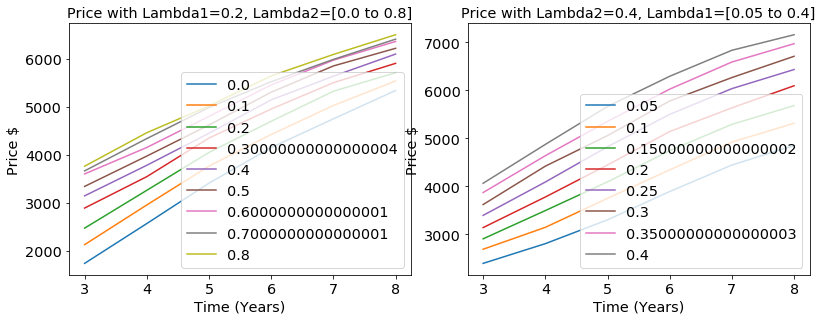

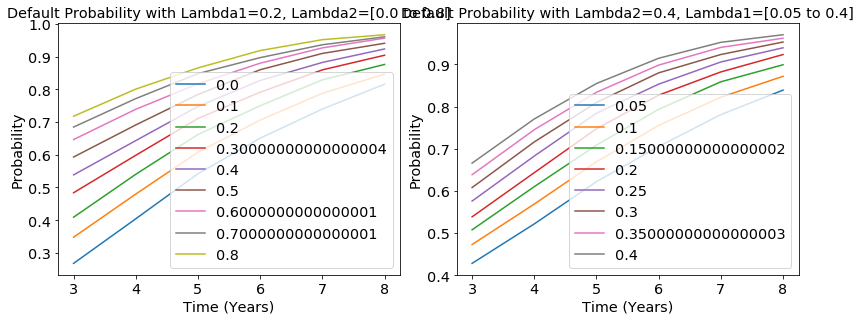

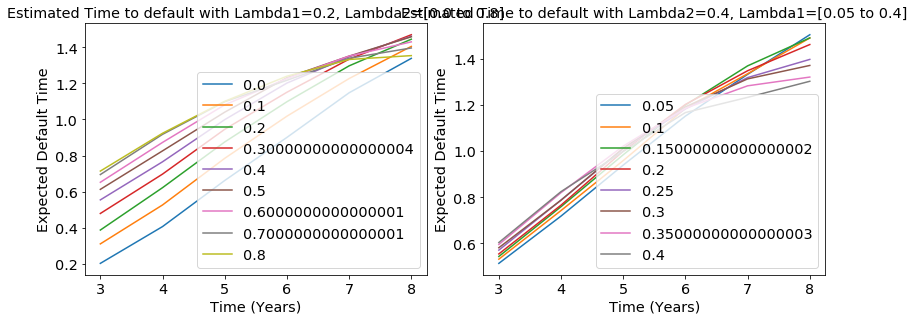

In [7]:
######################## 2 (i)  ########################
[D, P, Et] = Proj6_2func(lambda1=0.2, lambda2=0.4, T=5) 

######################## 2 (ii)  #######################

vfunc=np.vectorize(Proj6_2func)

fig1, axe1 = plt.subplots(1, 2)
fig1.tight_layout(pad=0.5, w_pad=1.5, h_pad=2.0)
fig2, axe2 = plt.subplots(1, 2)
fig2.tight_layout(pad=0.5, w_pad=1.5, h_pad=2.0)
fig3, axe3 = plt.subplots(1, 2)
fig3.tight_layout(pad=0.5, w_pad=1.5, h_pad=2.0)

#### fixed lambda1 and floating lambda2
lambda1 = 0.2
lambda2 = np.arange(0.0, 0.8+0.1, 0.1)
T = np.arange(3, 8+1, 1)

prices1 = np.zeros((len(lambda2), len(T)))
defaultProb1 = np.zeros((len(lambda2), len(T)))
Etime1 = np.zeros((len(lambda2), len(T)))

for i in range(len(lambda2)):
    prices1[i, :], defaultProb1[i, :], Etime1[i, :] = vfunc(0.2, lambda2[i], T)

##plotting

for price, prob, time, label in zip(prices1, defaultProb1, Etime1, lambda2):
    axe1[0].plot(T, price, label=label)
    axe2[0].plot(T, prob, label=label)
    axe3[0].plot(T, time, label=label)

axe1[0].legend()
axe2[0].legend()
axe3[0].legend()

 
    
#### fixed lambda2 and floating lambda1
lambda1 = np.arange(0.05, 0.4+0.05, 0.05)
lambda2 = 0.4

prices2 = np.zeros((len(lambda1), len(T)))
defaultProb2 = np.zeros((len(lambda1), len(T)))
Etime2 = np.zeros((len(lambda1), len(T)))

for i in range(len(lambda1)):
    prices2[i, :], defaultProb2[i, :], Etime2[i, :] = vfunc(lambda1[i], 0.4, T)

##Plotting
for price, prob, time, label in zip(prices2, defaultProb2, Etime2, lambda1):
    axe1[1].plot(T, price, label=label)
    axe2[1].plot(T, prob, label=label)
    axe3[1].plot(T, time, label=label)

axe1[1].legend()
axe2[1].legend()
axe3[1].legend()

axe1[0].set_title("Price with Lambda1=0.2, Lambda2=[0.0 to 0.8]")
axe2[0].set_title("Default Probability with Lambda1=0.2, Lambda2=[0.0 to 0.8]")
axe3[0].set_title("Estimated Time to default with Lambda1=0.2, Lambda2=[0.0 to 0.8]")
axe1[0].set_ylabel("Price $")
axe1[0].set_xlabel("Time (Years)")
axe2[0].set_ylabel("Probability")
axe2[0].set_xlabel("Time (Years)")    
axe3[0].set_ylabel("Expected Default Time")
axe3[0].set_xlabel("Time (Years)") 

axe1[1].set_title("Price with Lambda2=0.4, Lambda1=[0.05 to 0.4]")
axe2[1].set_title("Default Probability with Lambda2=0.4, Lambda1=[0.05 to 0.4]")
axe3[1].set_title("Estimated Time to default with Lambda2=0.4, Lambda1=[0.05 to 0.4]")
axe1[1].set_ylabel("Price $")
axe1[1].set_xlabel("Time (Years)")   
axe2[1].set_ylabel("Probability")
axe2[1].set_xlabel("Time (Years)")
axe3[1].set_ylabel("Expected Default Time")
axe3[1].set_xlabel("Time (Years)")
  
